Project Name: Fitness Bot

By Ron Thomas, Andrew Tong, Sukhveer Sahota, Andrew Kim

# Environment Setup Code

This section includes code to install and import all required modules, extract the dataset files, and set up a PyTorch Dataset object to generate samples from those files.

In [1]:
%%capture
!pip install av

In [ ]:
%%capture
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import os
import cv2
import json
import glob

In [ ]:
%%capture
# Security Note:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Even though we are sharing the same colab notebook,
# your VM is private to you, so only you have access to any files on it
# (this means you can safely mount your drive as you'll still be the only
# person with access to all its files from within Colab)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Mount Google Drive at a temporary path within your local runtime
from google.colab import drive
drive.mount('/content/drive')

# Copy ZIP files from Google Drive mount to local runtime
for exercise_name in ("pushup", "overheadpress", "squat"):
  status = os.system(f"cp '/content/drive/MyDrive/APS360 Group Project/infinityai_fitness_basic_{exercise_name}_v1.0.zip' /content/{exercise_name}.zip")
  assert status == 0, "Copying failed"

# Copy custom training ("extra") dataset from Google Drive mount to local runtime
os.mkdir('/content/extra_data')
for exercise_name in ("pushup", "overheadpress", "squat"):
  os.mkdir(f'/content/extra_data/{exercise_name}')
  status = os.system(f"cp '/content/drive/MyDrive/APS360 Group Project/Extra_data/{exercise_name}'/* /content/extra_data/{exercise_name}/")
  assert status == 0, "Copying failed"

# Copy test dataset from Google Drive mount to local runtime
os.mkdir('/content/test_dataset_root')
for exercise_name in ("pushup", "overheadpress", "squat"):
  os.mkdir(f'/content/test_dataset_root/{exercise_name}')
  status = os.system(f"cp '/content/drive/MyDrive/APS360 Group Project/Test folder/{exercise_name}'/* /content/test_dataset_root/{exercise_name}/")
  assert status == 0, "Copying failed"

# Copy saved model checkpoints, if they exist
saved_model_path = "/content/drive/MyDrive/APS360 Group Project/final_model_checkpoints"
if os.path.exists(saved_model_path):
  status = os.system(f"cp '{saved_model_path}'/*_model_latest /content/")
  assert status == 0, "Copying failed"

# Google Drive mount no longer needed. Unmount it...
drive.flush_and_unmount()

# Unzip each ZIP archive
for exercise_name in ("pushup", "overheadpress", "squat"):
  zip_dir = f"/content/{exercise_name}.zip"
  output_dir = f"/content/{exercise_name}_data/"
  if not os.path.isdir(output_dir):
    os.mkdir(output_dir)
  status = os.system(f"unzip {zip_dir} -d {output_dir}")
  assert status == 0, "Unzipping failed"
  os.remove(zip_dir)

# Organize data into the required directory structure:
#
# dataset_root
# |
# |--- overhead_press
# |    |--- 000000.mp4
# |    |--- 000001.mp4
# |    |---    ...
# |--- pushup
# |    |--- 000000.mp4
# |    |---    ...
# |--- squat
#      |--- 000000.mp4
#      |---    ...
dataset_root = "/content/dataset_root"
os.mkdir(dataset_root)
for exercise_name in ("pushup", "overheadpress", "squat"):
  unpacked_dataset_dir = f"/content/{exercise_name}_data/infinityai_fitness_basic_{exercise_name}_v1.0/data"
  os.rename(unpacked_dataset_dir, os.path.join(dataset_root, exercise_name))

# Cleanup any unneeded files
for exercise_name in ("pushup", "overheadpress", "squat"):
  os.system(f"rm -rf /content/{exercise_name}_data")
  dataset_dir = os.path.join(dataset_root, exercise_name)
  os.system(f"rm -f {dataset_dir}/*.json")
  os.system(f"rm -f {dataset_dir}/*_img_labels.zip")
os.system("rm -rf /content/sample_data")

# Dataset Augmentation Code

In [ ]:
%%capture
original_dataset_dir_infinity_ai = "/content/dataset_root"
original_dataset_dir_custom = "/content/extra_data"

transformed_dataset_dir = "/content/transformed_dataset_root"
os.mkdir(transformed_dataset_dir)
os.mkdir(f'{transformed_dataset_dir}/pushup')
os.mkdir(f'{transformed_dataset_dir}/overheadpress')
os.mkdir(f'{transformed_dataset_dir}/squat')

pushup_counter = 0
overheadpress_counter = 0
squat_counter = 0


# Copy infinity AI videos as-is
for video in glob.glob(os.path.join(original_dataset_dir_infinity_ai, "pushup/*.mp4")):
  os.system(f"cp {video} {transformed_dataset_dir}/pushup/")
  pushup_counter = pushup_counter + 1
for video in glob.glob(os.path.join(original_dataset_dir_infinity_ai, "overheadpress/*.mp4")):
  os.system(f"cp {video} {transformed_dataset_dir}/overheadpress/")
  overheadpress_counter = overheadpress_counter + 1
for video in glob.glob(os.path.join(original_dataset_dir_infinity_ai, "squat/*.mp4")):
  os.system(f"cp {video} {transformed_dataset_dir}/squat/")
  squat_counter = squat_counter + 1

# NUM_TRANSFORMS = 5
# augmentation_transforms = []
# augmentation_transforms.append(torchvision.transforms.Compose([
#   torchvision.transforms.ColorJitter(brightness=.5, hue=.3),
# ]))
# augmentation_transforms.append(torchvision.transforms.Compose([
#   torchvision.transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
# ]))
# augmentation_transforms.append(torchvision.transforms.Compose([
#   torchvision.transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
# ]))
# augmentation_transforms.append(torchvision.transforms.Compose([
#   torchvision.transforms.RandomRotation(degrees=(0, 180)),
# ]))
# augmentation_transforms.append(torchvision.transforms.Compose([
#   torchvision.transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
# ]))

# NUM_TIMES_TO_GENERATE = 20
NUM_TIMES_TO_GENERATE = 1

# Generate transformed versions of our custom data
for video_path in glob.glob(os.path.join(original_dataset_dir_custom, "pushup/*.mp4")):
  video, _, _ = torchvision.io.read_video(video_path, output_format="TCHW")
  for i in range(NUM_TIMES_TO_GENERATE):
    transformed_video = video #augmentation_transforms[i%NUM_TRANSFORMS](video)
    filename = f"{transformed_dataset_dir}/pushup/{pushup_counter:06}.mp4"
    transformed_video = torch.permute(transformed_video, (0,2,3,1))
    torchvision.io.write_video(filename, transformed_video, fps=24)
    pushup_counter = pushup_counter + 1
for video_path in glob.glob(os.path.join(original_dataset_dir_custom, "overheadpress/*.mp4")):
  video, _, _ = torchvision.io.read_video(video_path, output_format="TCHW")
  for i in range(NUM_TIMES_TO_GENERATE):
    transformed_video = video #augmentation_transforms[i%NUM_TRANSFORMS](video)
    filename = f"{transformed_dataset_dir}/overheadpress/{overheadpress_counter:06}.mp4"
    transformed_video = torch.permute(transformed_video, (0,2,3,1))
    torchvision.io.write_video(filename, transformed_video, fps=24)
    overheadpress_counter = overheadpress_counter + 1
for video_path in glob.glob(os.path.join(original_dataset_dir_custom, "squat/*.mp4")):
  video, _, _ = torchvision.io.read_video(video_path, output_format="TCHW")
  for i in range(NUM_TIMES_TO_GENERATE):
    transformed_video = video #augmentation_transforms[i%NUM_TRANSFORMS](video)
    filename = f"{transformed_dataset_dir}/squat/{squat_counter:06}.mp4"
    transformed_video = torch.permute(transformed_video, (0,2,3,1))
    torchvision.io.write_video(filename, transformed_video, fps=24)
    squat_counter = squat_counter + 1

# Dataset Cache Setup Code

In [ ]:
#@title Video Dataset Cache Populator
class DatasetCachePopulator():
    def __init__(self, root_dataset_dir, transform=None):
        self.transform = transform

        self.root_dataset_dir = root_dataset_dir
        self.num_pushup_samples = len(glob.glob(os.path.join(root_dataset_dir, "pushup/*.mp4")))
        self.num_overheadpress_samples = len(glob.glob(os.path.join(root_dataset_dir, "overheadpress/*.mp4")))
        self.num_squat_samples = len(glob.glob(os.path.join(root_dataset_dir, "squat/*.mp4")))

    def __len__(self):
        return self.num_pushup_samples + self.num_overheadpress_samples + self.num_squat_samples

    def __getitem__(self, idx):
        assert idx >= 0 and idx < self.__len__()

        target_class_dir = None
        target_class_idx = None
        image_idx = None
        if idx < self.num_pushup_samples:
          target_class_dir = "pushup"
          target_class_idx = 0
          image_idx = idx
        elif idx < self.num_pushup_samples + self.num_overheadpress_samples:
          target_class_dir = "overheadpress"
          target_class_idx = 1
          image_idx = idx - self.num_pushup_samples
        else:
          target_class_dir = "squat"
          target_class_idx = 2
          image_idx = idx - self.num_pushup_samples - self.num_overheadpress_samples

        video_path = os.path.join(self.root_dataset_dir, target_class_dir, f"{image_idx:06}.mp4")
        video, _, _ = torchvision.io.read_video(video_path, output_format="TCHW")
        # Convert pixel values from (0, 255) to floats in (0, 1)
        video = video.to(dtype=torch.float) / 255.0
        #TCHW = Total Frames/Channels/Height/Width
        if self.transform:
            video = self.transform(video)
        return target_class_dir, image_idx, video

    def run(self):
        cache_root = "/content/cached_dataset_root"
        if os.path.exists(cache_root):
          os.system(f"rm -rf {cache_root}")
        os.mkdir(cache_root)
        os.mkdir(os.path.join(cache_root, "pushup"))
        os.mkdir(os.path.join(cache_root, "overheadpress"))
        os.mkdir(os.path.join(cache_root, "squat"))
        for i in range(len(self)):
          target_class_dir, image_idx, video = self.__getitem__(i)
          cache_output_path = os.path.join(cache_root, target_class_dir, f"{image_idx:06}.tensor")
          torch.save(video, cache_output_path)


In [ ]:
%%capture

FRAMES_PER_SECOND = 24      # Fixed - it's a property of the input videos

FRAME_STRIDE = 6            # Extract every 8 frames (i.e. 3 frames for 1 second)
                            # Lower this number to enable more fine-grained sampling

NUM_SECONDS_PER_SAMPLE = 5  # A full sample covers 5 seconds of video

populator = DatasetCachePopulator(
    "/content/transformed_dataset_root/",
    transform=torchvision.transforms.Compose([
        # Trim video sample to its first X seconds, and sample frames uniformly across that interval
        torchvision.transforms.Lambda(lambda y : y[0:FRAMES_PER_SECOND*NUM_SECONDS_PER_SAMPLE:FRAME_STRIDE, :, :, :]),
        # Normalize pixel values from (0, 255) -> (0, 1)
        # torchvision.transforms.Normalize(mean=0, std=255),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)
populator.run()

# Training Setup Code

In [ ]:
#@title Custom Video Dataset
class CustomVideoDataset(torch.utils.data.Dataset):
    def __init__(self, root_dataset_dir, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform

        self.root_dataset_dir = root_dataset_dir
        self.num_pushup_samples = len(glob.glob(os.path.join(root_dataset_dir, "pushup/*.tensor")))
        self.num_overheadpress_samples = len(glob.glob(os.path.join(root_dataset_dir, "overheadpress/*.tensor")))
        self.num_squat_samples = len(glob.glob(os.path.join(root_dataset_dir, "squat/*.tensor")))

    def __len__(self):
        return self.num_pushup_samples + self.num_overheadpress_samples + self.num_squat_samples

    def __getitem__(self, idx):
        assert idx >= 0 and idx < self.__len__()

        target_class_dir = None
        target_class_idx = None
        image_idx = None
        if idx < self.num_pushup_samples:
          target_class_dir = "pushup"
          target_class_idx = 0
          image_idx = idx
        elif idx < self.num_pushup_samples + self.num_overheadpress_samples:
          target_class_dir = "overheadpress"
          target_class_idx = 1
          image_idx = idx - self.num_pushup_samples
        else:
          target_class_dir = "squat"
          target_class_idx = 2
          image_idx = idx - self.num_pushup_samples - self.num_overheadpress_samples

        video_path = os.path.join(self.root_dataset_dir, target_class_dir, f"{image_idx:06}.tensor")
        video = torch.load(video_path)
        # print(video_path)
        label = target_class_idx
        if self.transform:
            video = self.transform(video)
        if self.target_transform:
            label = self.target_transform(label)
        return video, label

In [ ]:
dataset = CustomVideoDataset(
    "/content/cached_dataset_root/",
)
# Each data sample will be a 4D tensor of size (15 x 3 x 224 x 224)
# 15 frames, 3 channels (RGB), 224x224 image
# The data in the tensor will be normalized to the range (0, 1)

Here we will create a train and validation data split

In [ ]:
# Adapted from: https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Examples: Loading and Visualizing the Data

In [ ]:
## Example use of above dataset using a PyTorch DataLoader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# below is how we go from multiple frames to 1 frame
# tensor_32x50x3x224x224 = torch.randn(32, 50, 3, 224, 224)

# # Extract the first sample from each batch
# sample_index = torch.arange(tensor_32x50x3x224x224.size(1))
# samples = tensor_32x50x3x224x224.index_select(1, sample_index)[..., 0, :, :]

# # Check the shape of the new tensor
# print(samples.shape)  # Output: torch.Size([32, 3, 224, 224])
for data in dataloader:
    frames, label = data
    print(frames.shape)
    print(frames[0].shape)
    print(label)
    print(frames[0][0])
    print(frames[:, 0,:,:,:].shape)
    break

In [ ]:
## Code to plot the frames of a video after preprocessing it
## Adapted from: https://pytorch.org/vision/stable/auto_examples/plot_optical_flow.html#optical-flow-predicting-movement-with-the-raft-model

plt.rcParams["savefig.bbox"] = "tight"


def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = torchvision.transforms.functional.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
for data in dataloader:
    frames, _ = data
    plot(torch.stack([frames[0][0], frames[0][1], frames[0][2], frames[0][3]]))
    plot(torch.stack([frames[0][4], frames[0][5], frames[0][6], frames[0][7]]))
    plot(torch.stack([frames[0][8], frames[0][9], frames[0][10], frames[0][11]]))
    break

# Baseline Model

Get the processed data and extract the frames. The baseline model will randomly select a frame in each example and use it to try and classify the images in the dataset. This will be used to compare with out model to judge the performance

In [ ]:
#@title Baseline Model Definition
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.name = "CNN"
        self.alexnet = torchvision.models.alexnet(pretrained=True)
        for p in self.alexnet.parameters():
          p.requires_grad = False
        self.fc1 = nn.Linear(256 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 3)

    def forward(self, x):
        x = self.alexnet.features(x) # 256 x 6 x 6
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
#@title Baseline Model Training Loop
def val_loss(model, val_loader):
  # calculate the validation set loss
  loss_total = 0
  criterion = nn.CrossEntropyLoss()
  i = 0
  device = torch.device('cuda')
  for data, label in val_loader:
          data = data.to(device=device)
          label = label.to(device=device)
          # Extract the first sample from each batch
          out = model(data[:,0,:,:,:])
          loss = criterion(out, label)
          loss_total += loss.item()
          i = i + 1
  return loss_total/(i)

def train(model, train_data, val_data, num_epochs, learning_rate, batch_size):
    """ Training loop. You should update this."""
    torch.manual_seed(42)

    #need to update the loader part or filter the data first before being passed here
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loss, valid_loss, train_accuracy, val_accuracy = [], [], [], []

    device = torch.device('cuda')
    model = model.to(device=device)
    for epoch in range(num_epochs):
      i = 0
      loss_total = 0
      for data, label in train_loader:
          data = data.to(device=device)
          label = label.to(device=device)
          # Extract the first frame from each sample in the batch
          out = model(data[:,0,:,:,:])
          loss = criterion(out, label)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          i = i + 1
          loss_total += loss.item()
      # store all the values at the end of each epoch
      train_accuracy.append(get_accuracy__baseline(model, train_loader))
      val_accuracy.append(get_accuracy__baseline(model, val_loader))
      # print(f'epoch : {epoch}, train_accuracy: {train_accuracy[-1]}, val_accuracy: {val_accuracy[-1]}')
      train_loss.append(loss_total/(i))
      valid_loss.append(val_loss(model, val_loader))
      print(f'epoch : {epoch}, train_loss: {train_loss[-1]}, val_loss: {valid_loss[-1]}, train_accuracy: {train_accuracy[-1]}, val_accuracy: {val_accuracy[-1]}')
      # print(f'epoch : {epoch}')
      torch.save(model.state_dict(), f"baseline_epoch_{epoch}")


    # # plotting
    plt.title("Training and validation loss curve")
    plt.plot(train_loss, label="Train")
    plt.plot(valid_loss, label="Validation")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training and validation accuracy curve")
    plt.plot(train_accuracy, label="Train")
    plt.plot(val_accuracy, label="Validation")
    plt.xlabel("epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

def get_accuracy__baseline(model, data_load):
    correct = 0
    total = 0
    device = torch.device('cuda')
    for imgs, labels in data_load:
        # plot(torch.stack((imgs[0][0],)))
        imgs = imgs.to(device=device)
        labels = labels.to(device=device)
        output = model(imgs[:,0,:,:,:])
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        # print(pred)
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

    return correct / total

epoch : 0, train_loss: 2.4690452069044113, val_loss: 0.7184706404805183, train_accuracy: 0.4609375, val_accuracy: 0.59375
epoch : 1, train_loss: 0.7092218594625592, val_loss: 0.6976380385458469, train_accuracy: 0.734375, val_accuracy: 0.578125
epoch : 2, train_loss: 0.5255062645301223, val_loss: 0.8631040006875992, train_accuracy: 0.80078125, val_accuracy: 0.59375
epoch : 3, train_loss: 0.4169538844143972, val_loss: 0.7065933365374804, train_accuracy: 0.90625, val_accuracy: 0.71875
epoch : 4, train_loss: 0.1893842605095415, val_loss: 1.1472369898110628, train_accuracy: 0.890625, val_accuracy: 0.703125
epoch : 5, train_loss: 0.12451796184541308, val_loss: 1.0882992828264832, train_accuracy: 0.95703125, val_accuracy: 0.75
epoch : 6, train_loss: 0.11310442834485457, val_loss: 0.9246230758726597, train_accuracy: 0.94140625, val_accuracy: 0.71875
epoch : 7, train_loss: 0.08077630341449549, val_loss: 0.8668368239887059, train_accuracy: 0.9609375, val_accuracy: 0.8125
epoch : 8, train_loss: 0

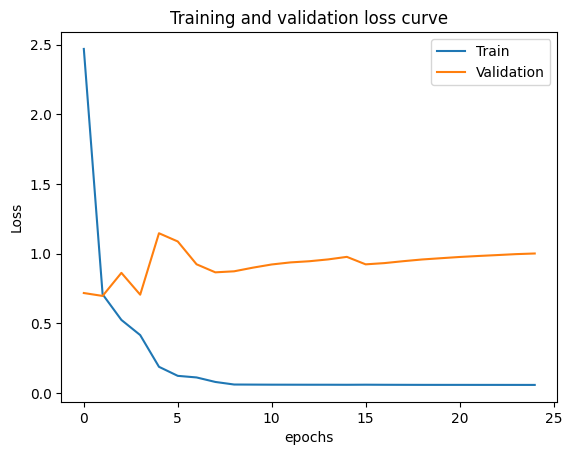

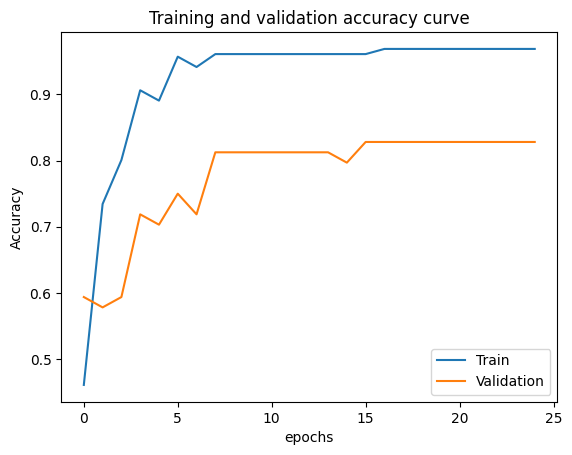

In [ ]:
model_baseline = CNN()
train(model_baseline, train_dataset, val_dataset, num_epochs=15, learning_rate=0.01, batch_size=8)

In [ ]:
torch.save(model_baseline.state_dict(), "baseline_model_latest")

# Primary Model (CNN+RNN Architecture)

In [ ]:
#@title Primary Model Definition
class ourCNN_RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(ourCNN_RNN, self).__init__()
    device = torch.device('cuda')
    self.alexnet = torchvision.models.alexnet(pretrained=True).to(device=device)
    for p in self.alexnet.parameters():
      p.requires_grad = False

    self.hidden_size = hidden_size

    self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
    self.dropout = nn.Dropout(p=0.2)
    self.fc1 = nn.Linear(2*hidden_size, 128)
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x):
    device = torch.device('cuda')

    # `x` is (<batch>, <frame>, <channel>, <height>, <width>)

    # Look up the embedding for each frame of each video in the batch
    # Produce `emb_inputs` which is (<batch>, <frame>, <feature embedding>)
    emb_inputs = torch.empty((x.shape[0], x.shape[1], 256*6*6), device=device)
    for i in range (x.shape[0]):
      input_to_alexnet = x[i,:,:,:,:]
      features = self.alexnet.features(x[i,:,:,:,:])

      emb_inputs[i] = features.reshape(x.shape[1],256*6*6)

    h0 = torch.zeros((1, emb_inputs.size(0), self.hidden_size), device=device)
    out, _ = self.rnn(emb_inputs, h0)
    # out = out[:, -1, :]
    out = torch.cat([
        torch.max(out, dim=1)[0],
        torch.mean(out, dim=1)
    ], dim=1)

    out = self.dropout(out)
    out = F.relu(self.fc1(out))
    out = self.dropout(out)
    out = self.fc2(out)
    return out

In [ ]:
#@title Primary Model Training Loop
def val_loss(model, val_loader):
  # calculate the validation set loss
  loss_total = 0
  criterion = nn.CrossEntropyLoss()
  i = 0
  device = torch.device('cuda')
  for data, label in val_loader:
          data = data.to(device=device)
          label = label.to(device=device)
          # Extract the first sample from each batch
          out = model(data)
          loss = criterion(out, label)
          loss_total += loss.item()
          i = i + 1
  return loss_total/(i)

def train(model, train_data, val_data, num_epochs, learning_rate, batch_size):
    """ Training loop. You should update this."""
    torch.manual_seed(42)

    #need to update the loader part or filter the data first before being passed here
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #, weight_decay=0.01)
    train_loss, valid_loss, train_accuracy, val_accuracy = [], [], [], []

    device = torch.device('cuda')
    model = model.to(device=device)
    for epoch in range(num_epochs):
      model.train()
      i = 0
      loss_total = 0
      for data, label in train_loader:
          data = data.to(device=device)
          label = label.to(device=device)
          # Extract the first sample from each batch
          out = model(data)
          loss = criterion(out, label)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          i = i + 1
          loss_total += loss.item()
      # store all the values at the end of each epoch
      train_accuracy.append(get_accuracy__primary(model, train_loader))
      val_accuracy.append(get_accuracy__primary(model, val_loader))
      # print(f'epoch : {epoch}, train_accuracy: {train_accuracy[-1]}, val_accuracy: {val_accuracy[-1]}')
      train_loss.append(loss_total/(i))
      valid_loss.append(val_loss(model, val_loader))
      print(f'epoch : {epoch}, train_loss: {train_loss[-1]}, val_loss: {valid_loss[-1]}, train_accuracy: {train_accuracy[-1]}, val_accuracy: {val_accuracy[-1]}')
      # print(f'epoch : {epoch}')
      torch.save(model.state_dict(), f"primary_epoch_{epoch}")


    # # plotting
    plt.title("Training and validation loss curve")
    plt.plot(train_loss, label="Train")
    plt.plot(valid_loss, label="Validation")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training and validation accuracy curve")
    plt.plot(train_accuracy, label="Train")
    plt.plot(val_accuracy, label="Validation")
    plt.xlabel("epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

def get_accuracy__primary(model, data_load):
    model.eval()
    correct = 0
    total = 0
    device = torch.device('cuda')
    for imgs, labels in data_load:
        imgs = imgs.to(device=device)
        labels = labels.to(device=device)
        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

    return correct / total

epoch : 0, train_loss: 1.142504334449768, val_loss: 0.9166317582130432, train_accuracy: 0.76171875, val_accuracy: 0.734375
epoch : 1, train_loss: 0.8320439241149209, val_loss: 0.9242896238962809, train_accuracy: 0.75390625, val_accuracy: 0.59375
epoch : 2, train_loss: 0.6297905743122101, val_loss: 0.7298965056737264, train_accuracy: 0.703125, val_accuracy: 0.578125
epoch : 3, train_loss: 0.492901474237442, val_loss: 0.6077749331792196, train_accuracy: 0.8828125, val_accuracy: 0.765625
epoch : 4, train_loss: 0.436659422787753, val_loss: 0.5206836462020874, train_accuracy: 0.90625, val_accuracy: 0.828125
epoch : 5, train_loss: 0.4042946574362842, val_loss: 0.7997433940569559, train_accuracy: 0.83984375, val_accuracy: 0.734375
epoch : 6, train_loss: 0.37644352289763366, val_loss: 0.7734663486480713, train_accuracy: 0.94140625, val_accuracy: 0.6875
epoch : 7, train_loss: 0.231210933490233, val_loss: 0.504055937131246, train_accuracy: 0.9375, val_accuracy: 0.8125
epoch : 8, train_loss: 0.19

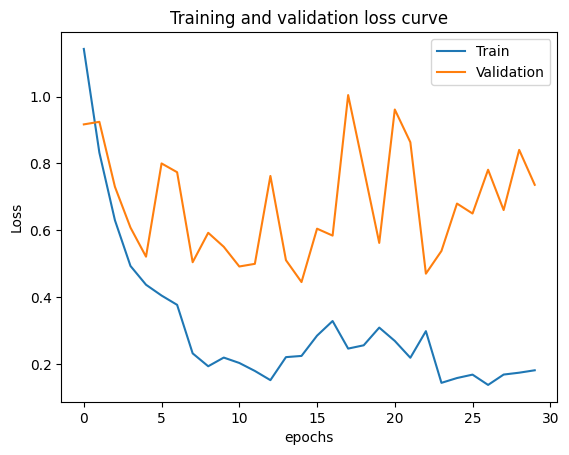

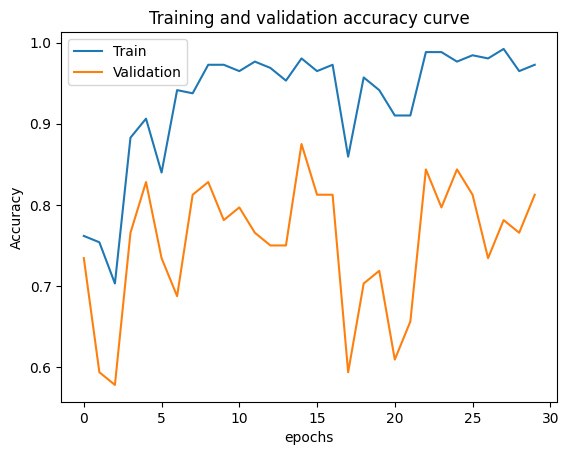

In [ ]:
model_cnn_rnn = ourCNN_RNN(256*6*6, 250, 3 )
train(model_cnn_rnn,train_dataset, val_dataset, num_epochs=30, learning_rate=0.01, batch_size=24)

# Testing Code

In [ ]:
%%capture

FRAMES_PER_SECOND = 24      # Fixed - it's a property of the input videos

FRAME_STRIDE = 6            # Extract every 8 frames (i.e. 3 frames for 1 second)
                            # Lower this number to enable more fine-grained sampling

NUM_SECONDS_PER_SAMPLE = 3  # A full sample covers 5 seconds of video

populator = DatasetCachePopulator(
    "/content/test_dataset_root/",
    transform=torchvision.transforms.Compose([
        # Trim video sample to its first X seconds, and sample frames uniformly across that interval
        torchvision.transforms.Lambda(lambda y : y[0:FRAMES_PER_SECOND*NUM_SECONDS_PER_SAMPLE:FRAME_STRIDE, :, :, :]),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
)
populator.run()

In [ ]:
test_dataset = CustomVideoDataset(
    "/content/cached_dataset_root/",
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

# Baseline
model_baseline = CNN()
model_baseline.eval()
model_baseline = model_baseline.to(device="cuda")
model_baseline.load_state_dict(torch.load(f"/content/baseline_model_latest"))
test_accuracy_baseline = get_accuracy__baseline(model_baseline, test_loader)
print(f"Baseline test accuracy: {test_accuracy_baseline * 100}%")
# Primary
model_primary = ourCNN_RNN(256*6*6, 250, 3 )
model_primary = model_primary.to(device="cuda")
model_primary.load_state_dict(torch.load(f"/content/primary_model_latest"))
test_accuracy_primary = get_accuracy__primary(model_primary, test_loader)
print(f"Primary test accuracy: {test_accuracy_primary * 100}%")

# Demo Code (Temporary)

In [ ]:
#@title Video Read, Plot, and Predict Code
def read_video_and_plot_and_predict(video_path, model):
    # Read
    video, _, _ = torchvision.io.read_video(video_path, output_format="TCHW")

    # Plot
    plot(torch.stack([
        video[0],
        video[24],
        video[48],
    ]))
    plot(torch.stack([
        video[72],
        video[96],
        video[120],
    ]))

    # Predict
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Lambda(lambda y : y.to(dtype=torch.float) / 255.0),
        torchvision.transforms.Lambda(lambda y : y[0:FRAMES_PER_SECOND*NUM_SECONDS_PER_SAMPLE:FRAME_STRIDE, :, :, :]),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    video = transform(video)
    prediction = model(video.unsqueeze(0).to(device=torch.device("cuda")))[0]
    prediction = F.softmax(prediction, dim=0)
    assert prediction.numel() == 3
    print(f"Pushup:\n\t{prediction[0].item() * 100}%")
    print(f"Overhead Press:\n\t{prediction[1].item() * 100}%")
    print(f"Squat:\n\t{prediction[2].item() * 100}%")

In [ ]:
%%capture
model_primary = ourCNN_RNN(256*6*6, 250, 3).to(device=torch.device("cuda"))
model_primary.load_state_dict(torch.load(f"/content/primary_model_latest"))
model_primary.eval()

In [ ]:
read_video_and_plot_and_predict("/content/test_dataset_root/overheadpress/000000.mp4", model_primary)

In [ ]:
read_video_and_plot_and_predict("/content/test_dataset_root/overheadpress/000001.mp4", model_primary)

In [ ]:
read_video_and_plot_and_predict("/content/test_dataset_root/squat/000000.mp4", model_primary)

In [ ]:
read_video_and_plot_and_predict("/content/test_dataset_root/squat/000001.mp4", model_primary)

In [ ]:
read_video_and_plot_and_predict("/content/test_dataset_root/pushup/000000.mp4", model_primary)

In [ ]:
read_video_and_plot_and_predict("/content/test_dataset_root/pushup/000001.mp4", model_primary)